Press model num :63
(446242, 30, 6)
(446242, 1)
5165.0


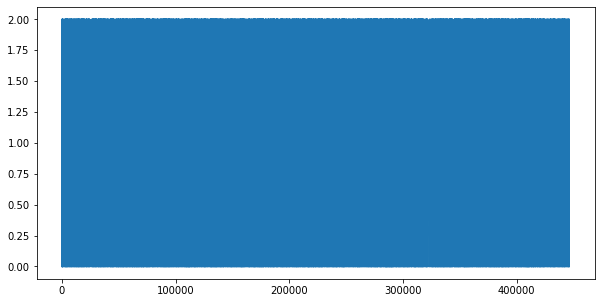

(312369, 30, 6, 1)
(66937, 30, 6, 1)
(66936, 30, 6, 1)


Using TensorFlow backend.
/home/lab23/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lab23/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lab23/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lab23/.local/lib/python3.6/site-packages/tensorflow/python/fra

[0. 1. 0. ... 2. 0. 0.]
{0: 0.335947834728236, 1: 83.83494363929147, 2: 87.57190916736754}
(312369, 3)
(66937, 3)
(66936, 3)


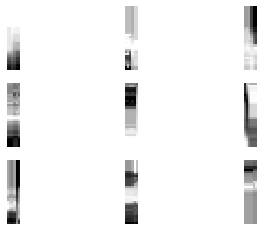


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 30, 6, 1)          0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 30, 6, 100)        1000      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 6, 100)        400       
_________________________________________________________________
pool1_1 (MaxPooling2D)       (None, 15, 3, 100)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 15, 3, 100)        90100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 3, 100)        400       
_________________________________________________________________
pool2_1 (MaxPooling2D)       (None, 7, 1, 100)         0  

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import pandas as pd
import numpy as np
from matplotlib import pyplot
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display
%matplotlib inline

# input_data_length = int(input('input_data_length : '))
input_data_length = 30
model_num = input('Press model num :')

Made_X = np.load('Made_X/Made_X %s_%s.npy' % (input_data_length, model_num))
Made_Y = np.load('Made_X/Made_Y %s_%s.npy' % (input_data_length, model_num))


#       dataset 분리      #
# dataX 구성 : VOLUME, MA, CMO, OBV, RSI, MACD, MACD_SIGNAL, MACD_OSC 
Made_X = Made_X[:, :,[0,1,2,3,5,7]]
print(Made_X.shape)
print(Made_Y.shape)
print(np.sum(Made_Y))

pyplot.figure(figsize=(10,5))
pyplot.plot(Made_Y)
pyplot.show()

row = Made_X.shape[1]
col = Made_X.shape[2]

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Made_X, Made_Y, test_size=0.3,
                                                   shuffle=False)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5,
                                                   shuffle=False)

X_train = X_train.astype('float32').reshape(-1, input_data_length, col, 1)
X_val = X_val.astype('float32').reshape(-1, input_data_length, col, 1)
X_test =X_test.astype('float32').reshape(-1, input_data_length, col, 1)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 

# Data Class Weight
from sklearn.utils import class_weight

print(Y_train[:, 0])
class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(Y_train[:, 0]),
                                                  Y_train[:, 0])
class_weights = dict(enumerate(class_weights))
print(class_weights)

Y_train = Y_train.astype('float32')
Y_val = Y_val.astype('float32')
Y_test = Y_test.astype('float32')
num_classes = 3
Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_val = np_utils.to_categorical(Y_val, num_classes)
Y_test = np_utils.to_categorical(Y_test, num_classes)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

datagen = ImageDataGenerator( 
#     rotation_range = 60,
#     zoom_range = 0.6,
#     shear_range = 0.6,
#     horizontal_flip = True,
    width_shift_range=0.6,
    height_shift_range=0.6,
    fill_mode = 'nearest'
    )

testgen = ImageDataGenerator( 
    )
datagen.fit(X_train)
batch_size = 128

for X_batch, _ in datagen.flow(X_train, Y_train, batch_size=9):
    for i in range(0, 9): 
        pyplot.axis('off') 
        pyplot.subplot(330 + 1 + i) 
        pyplot.imshow(X_batch[i].reshape(input_data_length, col), cmap=pyplot.get_cmap('gray'))
    pyplot.axis('off') 
    pyplot.show() 
    break
    
    
train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, Y_val, batch_size=batch_size) 
test_flow = testgen.flow(X_test, Y_test, batch_size=batch_size)


from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import LSTM, TimeDistributed, Input, Dense, Flatten, Dropout, BatchNormalization, Conv1D, LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix

def FER_Model(input_shape=(input_data_length, col, 1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    conv1_fit = 100
    conv2_fit = 100
    conv3_fit = 32
    # conv4_fit = 256
    # conv5_fit = 256

    #the 1-st block
    conv1_1 = Conv2D(conv1_fit, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
#     conv1_1 = LeakyReLU(alpha=0.05)(conv1_1)
    conv1_1 = BatchNormalization()(conv1_1)
    # conv1_2 = Conv2D(conv1_fit, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    # conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_1)
    # drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(conv2_fit, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(pool1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    # conv2_2 = Conv2D(conv2_fit, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    # conv2_2 = BatchNormalization()(conv2_2)
    # conv2_3 = Conv2D(conv2_fit, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    # conv2_3 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_1)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop2_1)
    dense = Dense(100, activation='relu', name='dense')(flatten)
    output = Dense(num_classes, activation='softmax', name = 'output')(dense)

    # create model 
    model = Model(inputs =visible, outputs = output)
    # summary layers
    print(model.summary())
    
    return model

model = FER_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# callbacks log 를 저장시키는 방법 예시
from keras.callbacks import Callback
import pickle

class Checkpoint_History(Callback):

    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_loss = []
        self.acc = []
        self.val_acc = []      

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
    
    
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
filepath="model/rapid_ascending %s_%s_maobv.hdf5" % (input_data_length, model_num)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint2 = TensorBoard(log_dir='Tensorboard_graph',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
checkpoint3 = EarlyStopping(monitor='val_loss', patience=15)
callbacks_list = [checkpoint, checkpoint2, checkpoint3]

# keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

# we iterate 200 times over the entire training set
num_epochs = 100
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    class_weight=class_weights,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size,
                    shuffle=False)



In [ ]:
from keras.models import load_model

model = load_model('model/rapid_ascending %s_%s.hdf5' % (input_data_length, model_num))
# model = load_model('/content/gdrive/My Drive/Colab Notebooks/model/rapid_ascending %s.hdf5' % input_data_length)
# loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
# print("Test Loss " + str(loss[0]))
# print("Test Acc: " + str(loss[1]))

# loss = model.evaluate(X_val, Y_val) 
# print(X_val.shape)
# print(Y_val.shape)

# print("Val Loss " + str(loss[0]))
# print("Val Acc: " + str(loss[1]))

#     Prediction    #
Y_pred_ = model.predict(X_test, verbose=1)

# Y_pred = Y_pred_[:,[-1]]
# print(Y_pred.shape)
# print(Y_test.shape)
Y_pred = np.argmax(Y_pred_, axis=1)
t_te = np.argmax(Y_test, axis=1)

#     Manual processing     #
Y_pred_one = Y_pred_[:, [-1]]
print(Y_pred_)
max_value = np.max(Y_pred_one)
print(max_value)

limit_line = 0.9
Y_pred_one = np.where(Y_pred_one > max_value * limit_line, 1, 0)

# print(Y_pred_one)
Y_pred_one = Y_pred_one.reshape(-1,)
# print(Y_pred_1)
# print(Y_pred.shape)
# print(t_te.shape)

# fail = 0
# fail2 = 0
# for i in range(len(Y_pred)):
#   if Y_pred_1[i] != t_te[i]:
#     fail += 1

#   if Y_pred[i] != t_te[i]:
#     fail2 += 1

# print(1 - fail / len(Y_pred))
# print(1 - fail2 / len(Y_pred))

# print(np.sum(Y_pred), np.sum(t_te))
# print('Y_pred / Y_test :', np.sum(Y_pred) / np.sum(t_te))
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(100,10))
plt.subplot(211)
plt.plot(Y_test, 'purple', label='test')

plt.subplot(212)
plt.plot(Y_pred_one, 'y', label='pred')
plt.show()
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/model/rapid_ascending %s.png' % input_data_length)
# plt.close()